# Temperature forecasting with RNN

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os

## Loading the dataset

In [61]:
# Data source https://data.gov.il/
from google.colab import files
uploaded = files.upload()

Saving ims_data.csv to ims_data (1).csv


In [71]:
import io
df = pd.read_csv(io.BytesIO(uploaded['ims_data.csv']),usecols=['date', 'time', 'temp'])
df.head()

,date,time,temp
0,01-08-2004,02:00,25.2
1,01-08-2004,05:00,24.2
2,01-08-2004,08:00,27.3
3,01-08-2004,11:00,31.3
4,01-08-2004,14:00,29.7


## Preprocessing and feature extraction

In [0]:
def to_international_date(d):
  date = d.split('-')

  day   = date[0]
  month = date[1]
  year  = date[2]

  return '%s-%s-%s' % (year, month, day)

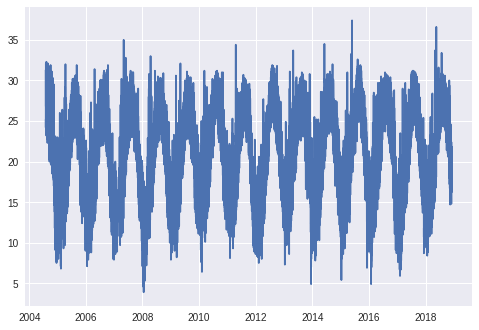

In [73]:
# Convert to the date format
df['date'] = df['date'].apply(to_international_date)

# Convert date and time to datetime
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

# Drop columns
df = df.drop(['date', 'time'], axis=1)

# Clean the data
df = df[df['temp'] != '-']

# Set the type of temp to float
df['temp'] = df['temp'].astype(float)

# Plot and describe the data
plt.plot(df['datetime'], df['temp'])

In [0]:
# Set the index
df = df.set_index('datetime')

In [77]:
# Describe
df.describe()

,temp
count,41142.000000
mean,21.582084
std,5.498377
min,3.900000
25%,17.300000
50%,21.900000
75%,26.500000
max,37.400000


In [76]:
df.info()

df.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41142 entries, 2004-08-01 02:00:00 to 2018-11-30 23:00:00
Data columns (total 1 columns):
temp    41142 non-null float64
dtypes: float64(1)
memory usage: 642.8 KB


(41142, 1)

In [78]:
# Separate between the train and test datasets 
## How to separate by time?
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test  = np.array(df[int(df.shape[0]*0.8):])

print(dataset_train.shape)
print(dataset_test.shape)

(32913, 1)
(8229, 1)


In [79]:
# Scale the datasets to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

dataset_train = scaler.fit_transform(dataset_train)
dataset_test  = scaler.transform(dataset_test)

print(dataset_train[:5]) # The first 5 data points
print(dataset_test[-5:]) # The last 5 data points

[[0.6358209 ]
 [0.60597015]
 [0.69850746]
 [0.81791045]
 [0.77014925]]
[[0.52835821]
 [0.53432836]
 [0.51940299]
 [0.51044776]
 [0.50746269]]


In [0]:
# Takes a series of 50 time points to label the next time point
def create_dataset(df):
  x = [] # features from the previous 50 time points
  y = [] # labels from the current time points
  
  for i in range(50, df.shape[0]):
    x.append(df[i-50:i,0])
    y.append(df[i,0])
    
  x = np.array(x)
  y = np.array(y)
  
  return x,y

In [81]:
x_train, y_train = create_dataset(dataset_train)
print(x_train[:1])
print(y_train[:1])

[[0.6358209  0.60597015 0.69850746 0.81791045 0.77014925 0.74328358
  0.70746269 0.68955224 0.68955224 0.68358209 0.77313433 0.84179104
  0.82686567 0.7641791  0.71343284 0.70447761 0.69552239 0.68656716
  0.74029851 0.74925373 0.75522388 0.73731343 0.71343284 0.70149254
  0.69552239 0.68656716 0.68358209 0.74029851 0.77014925 0.7641791
  0.70149254 0.68059701 0.61492537 0.59402985 0.67761194 0.74626866
  0.77910448 0.74029851 0.70447761 0.68955224 0.62985075 0.60895522
  0.68059701 0.75820896 0.80597015 0.74328358 0.70746269 0.69552239
  0.64477612 0.6358209 ]]
[0.68059701]


In [82]:
x_test, y_test = create_dataset(dataset_test)
print(x_test[:1])
print(y_test[:1])

[[0.20895522 0.36119403 0.40597015 0.39701493 0.39104478 0.29253731
  0.25373134 0.22985075 0.25373134 0.32835821 0.35223881 0.35223881
  0.34925373 0.34626866 0.34029851 0.29552239 0.32238806 0.31641791
  0.28059701 0.28358209 0.26567164 0.26865672 0.28656716 0.26268657
  0.24477612 0.23880597 0.25671642 0.22985075 0.1880597  0.14029851
  0.13731343 0.11044776 0.11641791 0.13134328 0.22089552 0.14029851
  0.11940299 0.11343284 0.08358209 0.10746269 0.11940299 0.20298507
  0.2238806  0.2238806  0.1880597  0.15820896 0.09552239 0.02985075
  0.06268657 0.22089552]]
[0.25671642]


In [0]:
# Reshape data for LSTM layer
# Make a 2 dimensional tuple into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test  = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

## Building the model

In [84]:
model = Sequential()

model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=96))
model.add(Dropout(0.2))

model.add(Dense(units=1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [86]:
model.fit(x_train,y_train,epochs=50,batch_size=32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
32863/32863 [==============================] - 147s 4ms/step - loss: 0.0077
Epoch 2/50
 9408/32863 [=======>......................] - ETA: 1:44 - loss: 0.0062

KeyboardInterrupt: ignored

## Predicting and visualizing the results

In [0]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
# How to visualize the data?